In [1]:
import os
import pandas as pd
import sys
sys.path.insert(0, '/home/jupyter/')
from hourly_pollution_prediction.process_and_join.bbox import * 
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
#for image inpainting
from skimage import data
from skimage.morphology import disk, binary_dilation
from skimage.restoration import inpaint
import cv2 as cv
import xesmf as xe
import geopandas as gpd
import rioxarray
from rioxarray.merge import merge_arrays
from pathlib import Path

df = pd.read_csv("../../data/tempo_data/no2_tempo_files_df.csv")

timestamps_dt = pd.to_datetime(df['timestamp_ct'])
unique_months = timestamps_dt.dt.to_period('M').unique()

# Compare to a Period object, not a string
# months = [pd.Period('2025-01', freq='M'), pd.Period('2025-02', freq='M'), pd.Period('2025-03', freq='M'),pd.Period('2025-04', freq='M'),pd.Period('2025-05', freq='M'), pd.Period('2025-06', freq='M')]
# unique_months = [month for month in unique_months if month in months]

In [ ]:
# Tried Denka -- no patterns, maybe because low nox and surrounding plants?
# International Paper  Natchitoches Parish paper mill

In [2]:
Lafeyette_xr_list = []

for month in unique_months:
    month_str = str(month)

    month_timestamps = timestamps_dt[timestamps_dt.dt.to_period('M') == month]
    days =month_timestamps.dt.to_period('d').unique()

    # LOOP THROUGH DAYS
    for day in days:
        day_str = str(day)

        ds = xr.open_dataset(f'../../data/tempo_data/no2_daily_files/tempo_{day_str}.nc', engine='netcdf4')

        ds['time'] = np.array(ds['time'], dtype='datetime64[ns]')
        ds['vertical_column_troposphere'] = ds['vertical_column_troposphere'].where(
            ds['main_data_quality_flag'] == 0, other=np.nan
        )
        ds = ds[["vertical_column_troposphere"]]

        # denka_lat = 30.05902
        # denka_lon = -90.52407
        lafayette_lat = 30.225
        lafayette_lon = -92.020
        
        ds = ds.where(
            (ds.longitude >= lafayette_lon - 0.1) & (ds.longitude <= lafayette_lon + 0.1) &
            (ds.latitude >= lafayette_lat - 0.1) & (ds.latitude <= lafayette_lat + 0.1),
            drop=True
        )
        # ds = ds[["vertical_column_troposphere"]]
        timestamp = day.to_timestamp()
        ds['vertical_column_troposphere'] = ds['vertical_column_troposphere']/1000000000000000
        Lafeyette_xr_list.append(ds)
combined_data = xr.concat(Lafeyette_xr_list, dim='time')
combined_data.to_netcdf(f'lafayette_no2.nc')


In [3]:
del Lafeyette_xr_list
import gc
gc.collect()

10

In [4]:
lakecharles_xr_list = []

for month in unique_months:
    month_str = str(month)

    month_timestamps = timestamps_dt[timestamps_dt.dt.to_period('M') == month]
    days =month_timestamps.dt.to_period('d').unique()

    # LOOP THROUGH DAYS
    for day in days:
        day_str = str(day)

        ds = xr.open_dataset(f'../../data/tempo_data/no2_daily_files/tempo_{day_str}.nc', engine='netcdf4')

        ds['time'] = np.array(ds['time'], dtype='datetime64[ns]')
        ds['vertical_column_troposphere'] = ds['vertical_column_troposphere'].where(
            ds['main_data_quality_flag'] == 0, other=np.nan
        )
        ds = ds[["vertical_column_troposphere"]]

        # denka_lat = 30.05902
        # denka_lon = -90.52407
        lakecharles_lat = 30.23
        lakecharles_lon =  -93.218

        ds = ds.where(
            (ds.longitude >= lakecharles_lon - 0.1) & (ds.longitude <= lakecharles_lon + 0.1) &
            (ds.latitude >= lakecharles_lat - 0.1) & (ds.latitude <= lakecharles_lat + 0.1),
            drop=True
        )
        # ds = ds[["vertical_column_troposphere"]]
        timestamp = day.to_timestamp()
        ds['vertical_column_troposphere'] = ds['vertical_column_troposphere']/1000000000000000
        lakecharles_xr_list.append(ds)
combined_data = xr.concat(lakecharles_xr_list, dim='time')
combined_data.to_netcdf(f'lakecharles_no2.nc')


In [5]:
combined_data

<xarray.Dataset> Size: 8MB
Dimensions:                      (time: 9503, latitude: 11, longitude: 10)
Coordinates:
  * latitude                     (latitude) float32 44B 30.13 30.15 ... 30.33
  * longitude                    (longitude) float32 40B -93.31 ... -93.13
  * time                         (time) datetime64[ns] 76kB 2023-08-02T10:47:...
Data variables:
    vertical_column_troposphere  (time, latitude, longitude) float64 8MB 3.89...

In [ ]:
del lakecharles_xr_list
import gc
gc.collect()

In [8]:
df = pd.read_csv("../../data/tempo_data/o3_tempo_files_df.csv")

timestamps_dt = pd.to_datetime(df['timestamp_ct'])
unique_months = timestamps_dt.dt.to_period('M').unique()

Lafeyette_xr_list = []

for month in unique_months:
    month_str = str(month)

    month_timestamps = timestamps_dt[timestamps_dt.dt.to_period('M') == month]
    days =month_timestamps.dt.to_period('d').unique()

    # LOOP THROUGH DAYS
    for day in days:
        day_str = str(day)

        ds = xr.open_dataset(f'../../data/tempo_data/o3_daily_files/tempo_o3_{day_str}.nc', engine='netcdf4')

        ds['time'] = np.array(ds['time'], dtype='datetime64[ns]')
        # ds['column_amount_o3'] = ds['vertical_column_troposphere'].where(
        #     ds['main_data_quality_flag'] == 0, other=np.nan
        # )
        ds = ds[["column_amount_o3"]]

        # denka_lat = 30.05902
        # denka_lon = -90.52407
        lafayette_lat = 30.225
        lafayette_lon = -92.020
        
        # Rename if necessary
        if 'lat' in ds.coords:
            ds = ds.rename({'lat': 'latitude'})
        if 'lon' in ds.coords:
            ds = ds.rename({'lon': 'longitude'})

        # Then apply filtering
        ds = ds.where(
            (ds.longitude >= lafayette_lon - 0.1) & (ds.longitude <= lafayette_lon + 0.1) &
            (ds.latitude >= lafayette_lat - 0.1) & (ds.latitude <= lafayette_lat + 0.1),
            drop=True
        )
        # ds = ds[["vertical_column_troposphere"]]
        timestamp = day.to_timestamp()
        # ds['column_amount_o3'] = ds['column_amount_o3']/1000000000000000
        Lafeyette_xr_list.append(ds)
combined_data = xr.concat(Lafeyette_xr_list, dim='time')
combined_data.to_netcdf(f'lafayette_o3.nc')


In [7]:
ds

<xarray.Dataset> Size: 7MB
Dimensions:           (time: 13, latitude: 240, longitude: 530)
Coordinates:
  * latitude          (latitude) float32 960B 28.61 28.63 28.65 ... 33.37 33.39
  * longitude         (longitude) float32 2kB -98.89 -98.87 ... -88.33 -88.31
  * time              (time) datetime64[ns] 104B 2024-12-01T07:02:54 ... 2024...
Data variables:
    column_amount_o3  (time, latitude, longitude) float32 7MB ...

In [2]:
df = pd.read_csv("../../data/tempo_data/o3_tempo_files_df.csv")

timestamps_dt = pd.to_datetime(df['timestamp_ct'])
unique_months = timestamps_dt.dt.to_period('M').unique()

lakecharles_xr_list = []

for month in unique_months:
    month_str = str(month)

    month_timestamps = timestamps_dt[timestamps_dt.dt.to_period('M') == month]
    days =month_timestamps.dt.to_period('d').unique()

    # LOOP THROUGH DAYS
    for day in days:
        day_str = str(day)

        ds = xr.open_dataset(f'../../data/tempo_data/o3_daily_files/tempo_o3_{day_str}.nc', engine='netcdf4')

        ds['time'] = np.array(ds['time'], dtype='datetime64[ns]')
        # ds['column_amount_o3'] = ds['vertical_column_troposphere'].where(
        #     ds['main_data_quality_flag'] == 0, other=np.nan
        # )
        ds = ds[["column_amount_o3"]]

        # denka_lat = 30.05902
        # denka_lon = -90.52407
        lakecharles_lat = 30.23
        lakecharles_lon =  -93.218
        
        # Rename if necessary
        if 'lat' in ds.coords:
            ds = ds.rename({'lat': 'latitude'})
        if 'lon' in ds.coords:
            ds = ds.rename({'lon': 'longitude'})

        # Then apply filtering
        ds = ds.where(
            (ds.longitude >= lakecharles_lon - 0.1) & (ds.longitude <= lakecharles_lon + 0.1) &
            (ds.latitude >= lakecharles_lat - 0.1) & (ds.latitude <= lakecharles_lat + 0.1),
            drop=True
        )
        # ds = ds[["vertical_column_troposphere"]]
        timestamp = day.to_timestamp()
        # ds['column_amount_o3'] = ds['column_amount_o3']/1000000000000000
        lakecharles_xr_list.append(ds)
combined_data = xr.concat(lakecharles_xr_list, dim='time')
combined_data.to_netcdf(f'lakecharles_o3.nc')


In [ ]:
# # 2. Aggregate to daily level by taking the mean NO₂ per day (or another agg function)
# df_daily = hourly_01.groupby(hourly_01['time'].dt.date).agg({'column_amount_o3': 'mean'}).reset_index()
# df_daily.rename(columns={'time': 'date'}, inplace=True)

# # 3. Plot
# plt.figure(figsize=(12, 6))
# plt.plot(df_daily['date'], df_daily['column_amount_o3'], marker='o')
# plt.xlabel('Date')
# plt.ylabel('NO₂ Concentration')
# plt.title('Daily NO₂ Concentration Over Time')
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.tight_layout()
# plt.show()
# plt.figure(figsize=(12, 6))


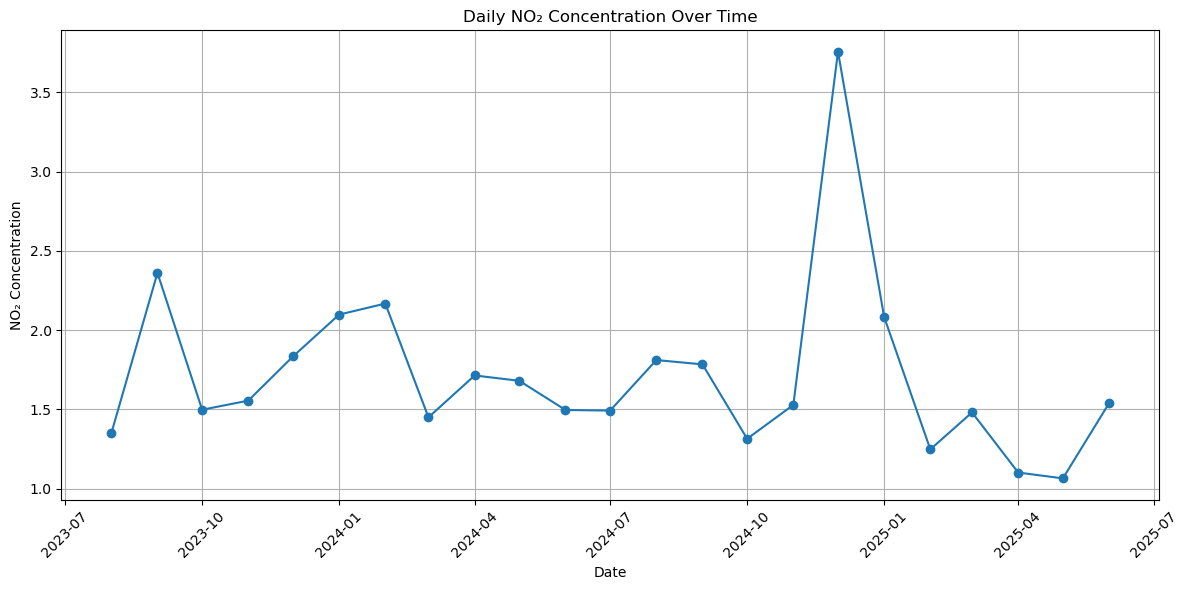

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [16]:
# 2. Aggregate to daily level by taking the mean NO₂ per day (or another agg function)
df_monthly = hourly_01.groupby(hourly_01['time'].dt.to_period('M')).agg({'vertical_column_troposphere': 'mean'}).reset_index()
df_monthly['time'] = df_monthly['time'].dt.to_timestamp()

# df_daily = hourly_01.groupby(hourly_01['time'].dt.date).agg({'vertical_column_troposphere': 'mean'}).reset_index()
# df_daily.rename(columns={'time': 'date'}, inplace=True)

# 3. Plot
plt.figure(figsize=(12, 6))
plt.plot(df_monthly['time'], df_monthly['vertical_column_troposphere'], marker='o')
plt.xlabel('Date')
plt.ylabel('NO₂ Concentration')
plt.title('Daily NO₂ Concentration Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 6))


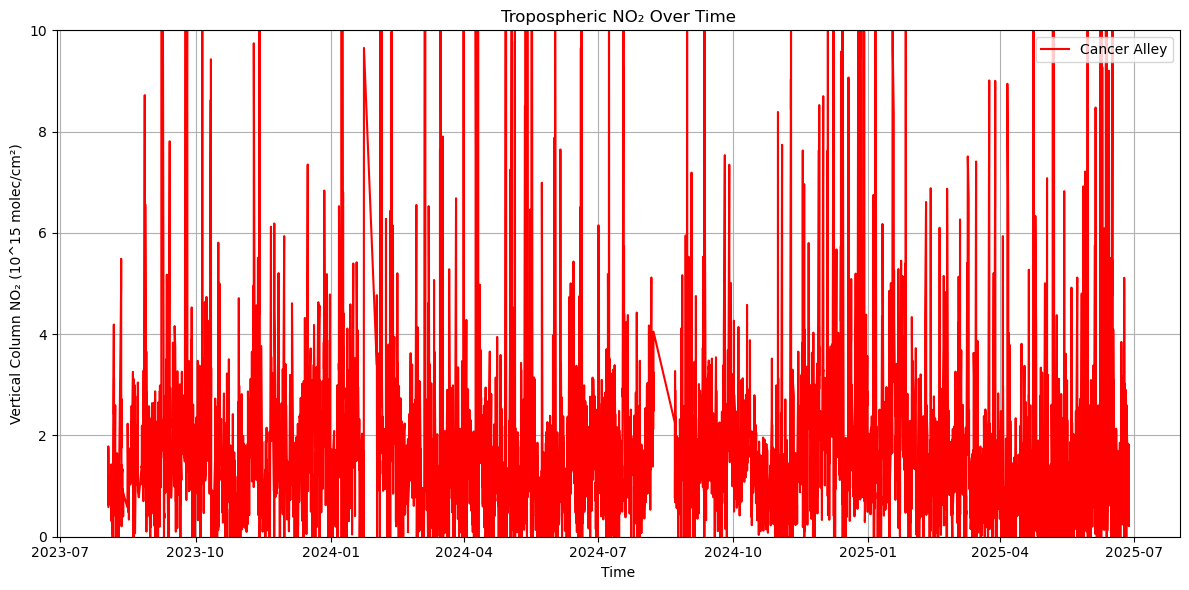

In [17]:

plt.figure(figsize=(12, 6))

# Plot each line
plt.plot(hourly_02['time'], hourly_02['vertical_column_troposphere'], label='Cancer Alley', color='red')

# Labels and title
plt.xlabel('Time')
plt.ylim(0,10)
plt.ylabel('Vertical Column NO₂ (10^15 molec/cm²)')
plt.title('Tropospheric NO₂ Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
